In [6]:
import os
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import librosa
import sys
import requests
sys.path.append("..")
from src.audio.utils import *

In [7]:
# old code on how to get baseline pronunciation using MW DICTIONARY API.
# NOTE: getting the actual audiofile has been hardcoded, should not be that way was just used for testing purposes offical way for any word
# can be found on MW's API website

# MW_LEARNER_API_KEY = os.environ.get("MW_LEARNER_API_KEY")
# word = "pronunciation"
# url = f"https://www.dictionaryapi.com/api/v3/references/learners/json/{word}"
# params = {
#     "key": MW_LEARNER_API_KEY
# }
#response = requests.get(url, params=params)
# response.status_code

# output_path = "pronunciation_mw.wav"

# resp = requests.get("https://media.merriam-webster.com/audio/prons/en/us/wav/p/pronun03.wav")

# with open(output_path, "wb") as f:
#     f.write(resp.content)

# output_path

## Test on word: Pronunciation (USER VS. MW DICTIONARY API AUDIO)

In [8]:
SR = 16000 # sample rate

# FRAME_MS controls smoothness
# HOP_MS controls time resolution
FRAME_MS = 25    # window size
HOP_MS   = 10    # step size

FRAME_LEN = int(SR * FRAME_MS / 1000)  # 400
HOP_LEN   = int(SR * HOP_MS / 1000)    # 160

user_path = "../data/pronunciation/pronunciation_full.wav"
mw_path = "../data/pronunciation/pronunciation_mw_16k.wav"

In [9]:
# audio from MW has been resampled to 16000 (user's sr) from previous notebook iteration shown below
# mw_16k = librosa.resample(audio.astype("float32"), orig_sr=sr_2, target_sr=16000)
# sf.write("../data/pronunciation/pronunciation_mw_16k.wav", mw_16k, 16000)

# load in each audio file and trim silence (even though MW probably will not have silence, just trim it to make sure both go through
# the same preprocessing

user_audio,u_sr = sf.read(user_path)
u_aud,_ = librosa.effects.trim(user_audio, top_db=30)

mw_audio,mw_sr = sf.read(mw_path)
mw_aud,_ = librosa.effects.trim(mw_audio, top_db=30)

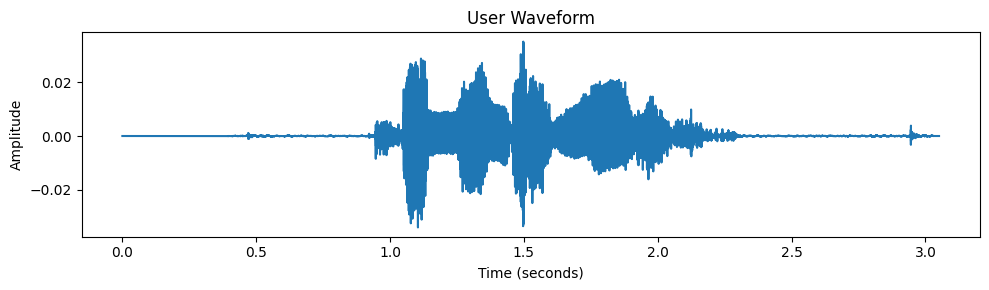

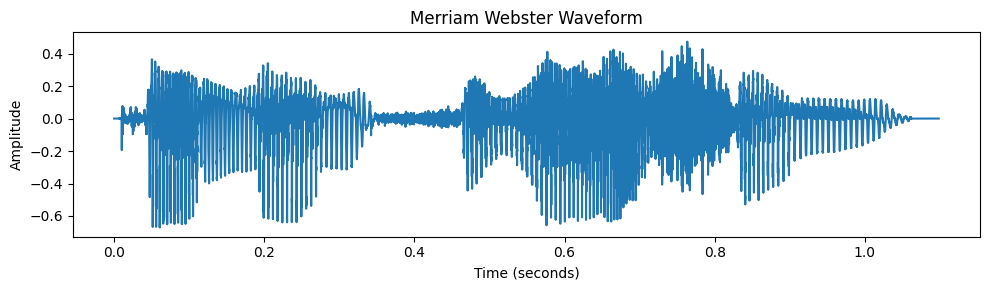

In [10]:
plot_waveform(user_audio,SR,title="User Waveform")
plot_waveform(mw_audio,SR,title="Merriam Webster Waveform")

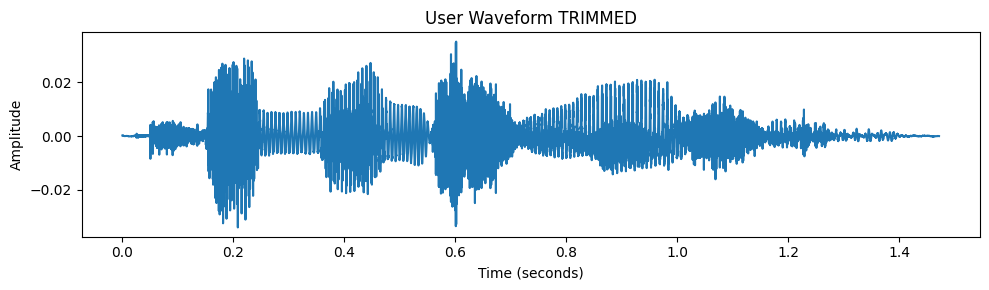

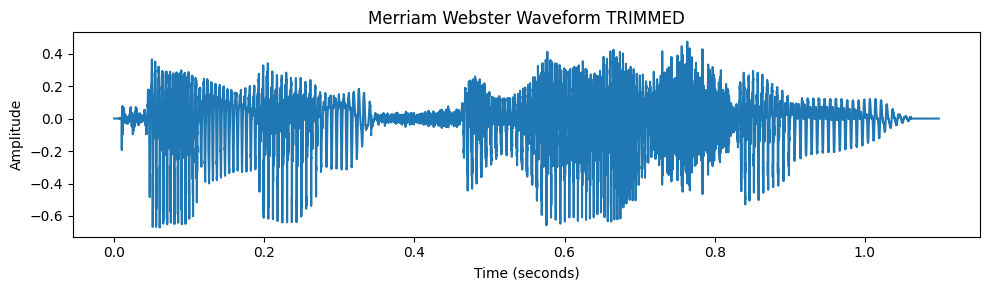

In [11]:
plot_waveform(u_aud,SR,title="User Waveform TRIMMED")
plot_waveform(mw_aud,SR,title="Merriam Webster Waveform TRIMMED")

In [12]:
audio_stats(u_aud, SR, "MY full")
audio_stats(mw_aud, SR, "MW baseline")

MY full: sr=16000, seconds=1.472, peak=0.035, rms=0.006
MW baseline: sr=16000, seconds=1.099, peak=0.670, rms=0.151


In [13]:
# normalizing the loudness of the baseline's audio to user's audio
mw_aud_norm = normalize_base_loudness(u_aud,mw_aud)

In [14]:
print("Before:")
print("USER  rms:", global_rms(u_aud))
print("MW  rms:", global_rms(mw_aud))
print("\nAfter:")
print("USER  rms:", global_rms(u_aud))
print("MW  rms:", global_rms(mw_aud_norm))

Before:
USER  rms: 0.0060386573928751415
MW  rms: 0.1505347148539661

After:
USER  rms: 0.0060386573928751415
MW  rms: 0.006038658


### The baseline audio is now has normalized loudness so they are compared against the same scale

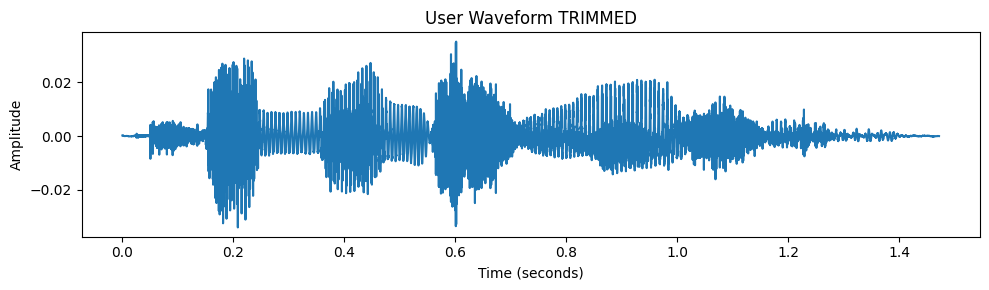

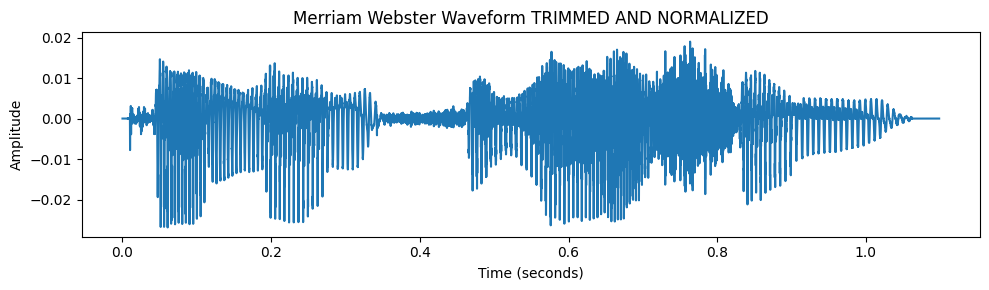

In [15]:
plot_waveform(u_aud,SR,title="User Waveform TRIMMED")
plot_waveform(mw_aud_norm,SR,title="Merriam Webster Waveform TRIMMED AND NORMALIZED")

### Convert waveforms into RMS envelopes for easier analysis

In [16]:
u_env = generate_rms_env(u_aud,FRAME_MS,HOP_MS,SR)
mw_env = generate_rms_env(mw_aud_norm,FRAME_MS,HOP_MS,SR)

In [40]:
# plot_env(u_env, SR, "MY loudness envelope")
# plot_env(mw_env, SR, "MW loudness envelope")

In [41]:
# import numpy as np
# from scipy.signal import find_peaks
# from scipy.ndimage import median_filter

# def detect_syllable_peaks_robust(
#     env,
#     sr=16000,
#     hop_len=160,
#     min_sep_ms=80,
#     smooth_ms=30,
#     prom_q=80,           # prominence reference quantile (robust)
#     prom_frac=0.25,      # prominence threshold as a fraction of prom_ref
#     height_q=60,         # minimum height threshold quantile
#     min_env_floor=1e-5,  # if envelope is basically zero, bail out
# ):
#     """
#     Robust peak detection on a loudness envelope.

#     Returns dict with:
#       peaks (frame indices),
#       peak_times (seconds),
#       peak_vals (env values at peaks),
#       primary_peak (frame index or None),
#       primary_time (seconds or None),
#       primary_rel_pos (0..1 or None),
#       debug thresholds (prominence/height used)
#     """

#     # env = np.asarray(env, dtype=np.float32)

#     if env.size < 3:
#         return {
#             "peaks": np.array([], dtype=int),
#             "peak_times": np.array([], dtype=np.float32),
#             "peak_vals": np.array([], dtype=np.float32),
#             "primary_peak": None,
#             "primary_time": None,
#             "primary_rel_pos": None,
#             "prom_used": None,
#             "height_used": None,
#         }

#     # If envelope energy is extremely low, treat as "no reliable speech"
#     env_max = float(np.max(env))
#     if env_max < min_env_floor:
#         return {
#             "peaks": np.array([], dtype=int),
#             "peak_times": np.array([], dtype=np.float32),
#             "peak_vals": np.array([], dtype=np.float32),
#             "primary_peak": None,
#             "primary_time": None,
#             "primary_rel_pos": None,
#             "prom_used": None,
#             "height_used": None,
#         }

#     # Smooth to reduce micro-peaks (median filter is robust to spikes)
#     hop_ms = 1000.0 * hop_len / sr
#     k = max(1, int(round(smooth_ms / hop_ms)))
#     # median_filter kernel size must be odd
#     if k % 2 == 0:
#         k += 1
#     env_s = median_filter(env, size=k)

#     # Convert min separation to frames
#     min_sep_frames = max(1, int(round((min_sep_ms / 1000.0) * sr / hop_len)))

#     # Robust thresholds based on percentiles (less sensitive than max)
#     prom_ref = float(np.percentile(env_s, prom_q))
#     prom = max(1e-9, prom_frac * prom_ref)

#     height = float(np.percentile(env_s, height_q))

#     peaks, props = find_peaks(
#         env_s,
#         distance=min_sep_frames,
#         prominence=prom,
#         height=height,
#     )

#     peak_vals = env[peaks]  # use original env values for reporting
#     peak_times = peaks.astype(np.float32) * (hop_len / sr)

#     # Primary stress candidate = tallest peak (on original env)
#     if peaks.size > 0:
#         primary_i = int(np.argmax(peak_vals))
#         primary_peak = int(peaks[primary_i])
#         primary_time = float(primary_peak * hop_len / sr)
#         total_dur = float((len(env) - 1) * hop_len / sr)
#         primary_rel_pos = primary_time / total_dur if total_dur > 0 else None
#     else:
#         primary_peak = None
#         primary_time = None
#         primary_rel_pos = None

#     return {
#         "peaks": peaks,
#         "peak_times": peak_times,
#         "peak_vals": peak_vals,
#         "primary_peak": primary_peak,
#         "primary_time": primary_time,
#         "primary_rel_pos": primary_rel_pos,
#         "prom_used": prom,
#         "height_used": height,
#     }
# my_pk = detect_syllable_peaks_robust(u_env, sr=SR, hop_len=HOP_LEN)
# mw_pk = detect_syllable_peaks_robust(mw_env, sr=SR, hop_len=HOP_LEN)

# print("MY peaks:", my_pk["peaks"])
# print("MW peaks:", mw_pk["peaks"])

# print("MY primary rel pos:", my_pk["primary_rel_pos"])
# print("MW primary rel pos:", mw_pk["primary_rel_pos"])

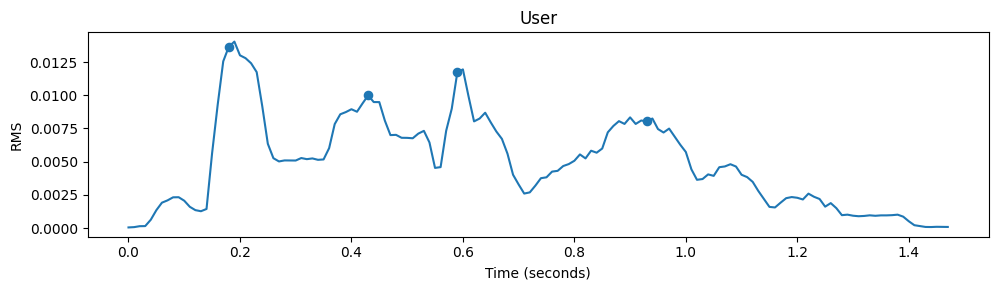

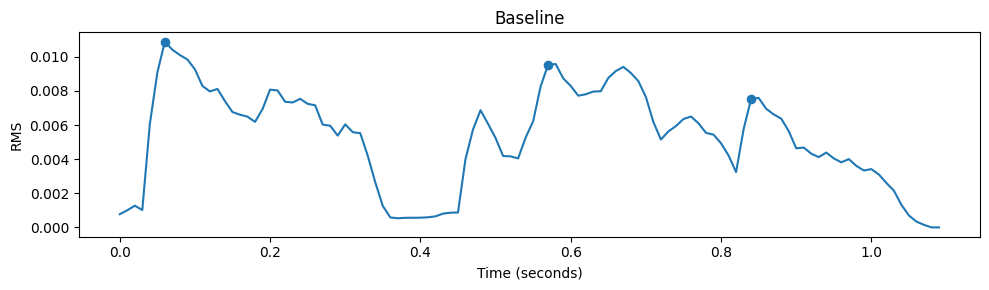

In [19]:
def plot_envelope_with_peaks(env, peaks, sr=16000, hop_len=160, title="Envelope + peaks"):
    # time axis for each envelope frame
    t = np.arange(len(env)) * (hop_len / sr)

    plt.figure(figsize=(10, 3))
    plt.plot(t, env, label="RMS envelope")
    if peaks is not None and len(peaks) > 0:
        plt.scatter(t[peaks], env[peaks], marker="o", s=35, label="peaks")
    plt.xlabel("Time (seconds)")
    plt.ylabel("RMS")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_envelope_with_peaks(u_env, my_pk["peaks"], sr=SR, hop_len=HOP_LEN, title="User")
plot_envelope_with_peaks(mw_env, mw_pk["peaks"], sr=SR, hop_len=HOP_LEN, title="Baseline")

In [42]:
# plot_envelope_with_peaks(u_env, my_peaks, sr=SR, hop_len=HOP_LEN, title="User")
# plot_envelope_with_peaks(mw_env,mw_peaks, sr=SR, hop_len=HOP_LEN, title="Baseline")

In [43]:
# from scipy.signal import find_peaks

# def detect_peaks(env, hop_len, sr=16000, min_sep_ms=80, prom_frac=0.08):
#     """
#     env: 1D loudness envelope (RMS)
#     min_sep_ms: minimum time separation between peaks (avoid double-peaks)
#     prom_frac: peak prominence threshold as fraction of max(env)
#     """
#     min_sep_frames = int((min_sep_ms / 1000) * sr / hop_len)  # ms -> seconds -> samples -> frames
#     prom = prom_frac * float(np.max(env))

#     peaks, props = find_peaks(env, distance=min_sep_frames, prominence=prom)
#     return peaks, props

# my_peaks, my_props = detect_peaks(u_env, HOP_LEN)
# mw_peaks, mw_props = detect_peaks(mw_env, HOP_LEN)

# print("MY peak frames:", my_peaks)
# print("MW peak frames:", mw_peaks)

In [32]:
import re, json
from pathlib import Path

VOWELS_ARPA = {
    "AA","AE","AH","AO","AW","AY","EH","ER","EY","IH","IY","OW","OY","UH","UW"
}

def is_vowel_phone(phone: str) -> bool:
    """ARPA vowel phones are like EY1, AH0, OW2 etc."""
    if not phone:
        return False
    base = re.sub(r"\d$", "", phone)  # strip stress digit
    return base in VOWELS_ARPA

def parse_textgrid_intervals(textgrid_path: str, tier_hint=("phones", "phone")):
    """
    Very simple TextGrid parser that extracts all intervals from the tier
    whose name contains 'phone' or 'phones'.
    Returns list of dicts: {tier, t0, t1, text}
    """
    p = Path(textgrid_path)
    s = p.read_text(encoding="utf-8", errors="ignore")

    # Find all tiers and their names
    # TextGrid format varies a bit; this works for MFA's "TextGrid short/long"
    # We'll scan tier blocks and pick the one with "phones" in its name.
    tier_blocks = re.split(r'\bitem \[\d+\]:', s)
    best_block = None
    best_name = None

    for block in tier_blocks[1:]:
        m = re.search(r'name\s*=\s*"([^"]+)"', block)
        if not m:
            continue
        name = m.group(1).lower()
        if any(h in name for h in tier_hint):
            best_block = block
            best_name = m.group(1)
            break

    if best_block is None:
        # fallback: try any tier named "phones"
        for block in tier_blocks[1:]:
            m = re.search(r'name\s*=\s*"([^"]+)"', block)
            if m and m.group(1).lower() == "phones":
                best_block = block
                best_name = m.group(1)
                break

    if best_block is None:
        raise RuntimeError("Could not find a phones tier in the TextGrid.")

    # Parse intervals within this tier
    intervals = []
    # MFA long TextGrid usually has: intervals [k]: xmin=... xmax=... text="..."
    for im in re.finditer(r'intervals \[\d+\]:\s*([^i]+)', best_block):
        chunk = im.group(1)
        xm = re.search(r'xmin\s*=\s*([0-9.]+)', chunk)
        xM = re.search(r'xmax\s*=\s*([0-9.]+)', chunk)
        tx = re.search(r'text\s*=\s*"([^"]*)"', chunk)
        if not (xm and xM and tx):
            continue
        t0 = float(xm.group(1))
        t1 = float(xM.group(1))
        text = tx.group(1).strip()
        intervals.append({"tier": best_name, "t0": t0, "t1": t1, "text": text})

    # Some MFA outputs use "intervals:" without indexes; fallback regex
    if not intervals:
        for m in re.finditer(r'xmin\s*=\s*([0-9.]+)\s*xmax\s*=\s*([0-9.]+)\s*text\s*=\s*"([^"]*)"', best_block):
            intervals.append({"tier": best_name, "t0": float(m.group(1)), "t1": float(m.group(2)), "text": m.group(3).strip()})

    return intervals

def extract_vowel_intervals(textgrid_path: str):
    intervals = parse_textgrid_intervals(textgrid_path)
    vowels = []
    for itv in intervals:
        ph = itv["text"]
        if is_vowel_phone(ph):
            stress = int(ph[-1]) if ph and ph[-1].isdigit() else None
            vowels.append({"phone": ph, "t0": itv["t0"], "t1": itv["t1"], "stress": stress})
    return vowels

# ---- run it ----
tg = r"pronunciation.TextGrid"  # <-- adjust if needed
vowels = extract_vowel_intervals(tg)

print("Vowel intervals:")
for v in vowels:
    print(v)

# Save cache JSON next to the TextGrid
cache = {
    "word": "pronunciation",
    "sr": 16000,
    "vowels": vowels,
}
out_json = r"pronunciation_mw_16k_vowels.json"
Path(out_json).write_text(json.dumps(cache, indent=2), encoding="utf-8")
print("Saved:", out_json)

Vowel intervals:
{'phone': 'AH0', 't0': 0.07, 't1': 0.12, 'stress': 0}
{'phone': 'AH2', 't0': 0.2, 't1': 0.27, 'stress': 2}
{'phone': 'IY0', 't0': 0.47, 't1': 0.58, 'stress': 0}
{'phone': 'EY1', 't0': 0.58, 't1': 0.7, 'stress': 1}
{'phone': 'AH0', 't0': 0.83, 't1': 0.91, 'stress': 0}
Saved: pronunciation_mw_16k_vowels.json


In [33]:
with open('pronunciation_mw_16k_vowels.json') as f:
    d = json.load(f)
    print(d)

{'word': 'pronunciation', 'sr': 16000, 'vowels': [{'phone': 'AH0', 't0': 0.07, 't1': 0.12, 'stress': 0}, {'phone': 'AH2', 't0': 0.2, 't1': 0.27, 'stress': 2}, {'phone': 'IY0', 't0': 0.47, 't1': 0.58, 'stress': 0}, {'phone': 'EY1', 't0': 0.58, 't1': 0.7, 'stress': 1}, {'phone': 'AH0', 't0': 0.83, 't1': 0.91, 'stress': 0}]}


In [44]:
tg_path = r"pronunciation.TextGrid"

text = Path(tg_path).read_text(encoding="utf-8", errors="ignore")

print(text)

File type = "ooTextFile"
Object class = "TextGrid"

xmin = 0 
xmax = 1.098563 
tiers? <exists> 
size = 2 
item []: 
    item [1]:
        class = "IntervalTier" 
        name = "words" 
        xmin = 0 
        xmax = 1.098563 
        intervals: size = 2 
        intervals [1]:
            xmin = 0.0 
            xmax = 1.05 
            text = "pronunciation" 
        intervals [2]:
            xmin = 1.05 
            xmax = 1.098563 
            text = "" 
    item [2]:
        class = "IntervalTier" 
        name = "phones" 
        xmin = 0 
        xmax = 1.098563 
        intervals: size = 13 
        intervals [1]:
            xmin = 0.0 
            xmax = 0.03 
            text = "P" 
        intervals [2]:
            xmin = 0.03 
            xmax = 0.07 
            text = "R" 
        intervals [3]:
            xmin = 0.07 
            xmax = 0.12 
            text = "AH0" 
        intervals [4]:
            xmin = 0.12 
            xmax = 0.2 
            text = "N" 
  

In [34]:
def interval_to_frames(t0, t1, sr, hop_len, n_frames):
    i0 = int(np.floor(t0 * sr / hop_len))
    i1 = int(np.ceil (t1 * sr / hop_len))
    i0 = max(0, min(n_frames-1, i0))
    i1 = max(0, min(n_frames,   i1))
    return i0, i1

def vowel_energy_scores(env, vowels, sr=16000, hop_len=160):
    n = len(env)
    scores = []
    for v in vowels:
        i0, i1 = interval_to_frames(v["t0"], v["t1"], sr, hop_len, n)
        seg = env[i0:i1]
        # robust energy summary inside vowel region
        energy = float(np.percentile(seg, 90)) if len(seg) else 0.0
        scores.append({**v, "i0": i0, "i1": i1, "energy_p90": energy})
    return scores

# load baseline vowel stencil
stencil = json.loads(Path("pronunciation_mw_16k_vowels.json").read_text())
baseline_vowels = stencil["vowels"]

# example: apply to user envelope
user_scores = vowel_energy_scores(u_env, baseline_vowels, sr=SR, hop_len=HOP_LEN)

# find strongest vowel region in user
best = max(user_scores, key=lambda d: d["energy_p90"])
print("Strongest vowel region:", best["phone"], best["t0"], best["t1"], "energy", best["energy_p90"])

# check if EY1 is strongest (stress match)
ey = [d for d in user_scores if d["phone"].endswith("1")]
ey_energy = ey[0]["energy_p90"] if ey else None
max_energy = best["energy_p90"]
print("EY1 energy:", ey_energy, "Max energy:", max_energy)

Strongest vowel region: AH2 0.2 0.27 energy 0.012875662185251713
EY1 energy: 0.011541507206857204 Max energy: 0.012875662185251713


In [35]:
print("SR:", SR)
print("HOP_LEN:", HOP_LEN)

n_frames = len(u_env)
dur_sec = (n_frames - 1) * (HOP_LEN / SR)

print("u_env frames:", n_frames)
print("u_env duration (sec):", dur_sec)

SR: 16000
HOP_LEN: 160
u_env frames: 148
u_env duration (sec): 1.47


In [36]:
print("mw_env frames:", len(mw_env))
print("mw_env duration (sec):", (len(mw_env) - 1) * (HOP_LEN / SR))

mw_env frames: 110
mw_env duration (sec): 1.09


In [37]:
u_dur  = (len(u_env)  - 1) * (HOP_LEN / SR)
mw_dur = (len(mw_env) - 1) * (HOP_LEN / SR)

a = u_dur / mw_dur  # stretch factor baseline->user
b = 0.0             # start shift (we’ll improve later)

print("stretch a:", a)

def map_interval(t0, t1, a, b):
    return a*t0 + b, a*t1 + b

# load your baseline vowel stencil dicts (the ones you printed earlier)
baseline_vowels = [
    {"phone":"AH0","t0":0.07,"t1":0.12,"stress":0},
    {"phone":"AH2","t0":0.20,"t1":0.27,"stress":2},
    {"phone":"IY0","t0":0.47,"t1":0.58,"stress":0},
    {"phone":"EY1","t0":0.58,"t1":0.70,"stress":1},
    {"phone":"AH0","t0":0.83,"t1":0.91,"stress":0},
]

mapped = []
for v in baseline_vowels:
    t0u, t1u = map_interval(v["t0"], v["t1"], a, b)
    mapped.append({**v, "t0_u": t0u, "t1_u": t1u})

mapped

stretch a: 1.348623853211009


[{'phone': 'AH0',
  't0': 0.07,
  't1': 0.12,
  'stress': 0,
  't0_u': 0.09440366972477064,
  't1_u': 0.16183486238532108},
 {'phone': 'AH2',
  't0': 0.2,
  't1': 0.27,
  'stress': 2,
  't0_u': 0.26972477064220185,
  't1_u': 0.36412844036697245},
 {'phone': 'IY0',
  't0': 0.47,
  't1': 0.58,
  'stress': 0,
  't0_u': 0.6338532110091742,
  't1_u': 0.7822018348623853},
 {'phone': 'EY1',
  't0': 0.58,
  't1': 0.7,
  'stress': 1,
  't0_u': 0.7822018348623853,
  't1_u': 0.9440366972477063},
 {'phone': 'AH0',
  't0': 0.83,
  't1': 0.91,
  'stress': 0,
  't0_u': 1.1193577981651375,
  't1_u': 1.2272477064220184}]

In [38]:
def interval_to_frames(t0, t1, sr, hop_len, n_frames):
    i0 = int(np.floor(t0 * sr / hop_len))
    i1 = int(np.ceil (t1 * sr / hop_len))
    i0 = max(0, min(n_frames-1, i0))
    i1 = max(0, min(n_frames,   i1))
    return i0, i1

scores = []
for v in mapped:
    i0, i1 = interval_to_frames(v["t0_u"], v["t1_u"], SR, HOP_LEN, len(u_env))
    seg = u_env[i0:i1]
    e90 = float(np.percentile(seg, 90)) if len(seg) else 0.0   # robust energy
    e50 = float(np.percentile(seg, 50)) if len(seg) else 0.0
    scores.append({**v, "i0": i0, "i1": i1, "e90": e90, "e50": e50})

for s in scores:
    print(f'{s["phone"]:<3} stress={s["stress"]}  '
          f'{s["t0_u"]:.3f}-{s["t1_u"]:.3f}s  frames={s["i0"]}-{s["i1"]}  '
          f'e90={s["e90"]:.6f}  e50={s["e50"]:.6f}')

best = max(scores, key=lambda d: d["e90"])
print("\nStrongest vowel region:", best["phone"], "stress", best["stress"])

AH0 stress=0  0.094-0.162s  frames=9-17  e90=0.006726  e50=0.001836
AH2 stress=2  0.270-0.364s  frames=26-37  e90=0.005275  e50=0.005169
IY0 stress=0  0.634-0.782s  frames=63-79  e90=0.008102  e50=0.004283
EY1 stress=1  0.782-0.944s  frames=78-95  e90=0.008160  e50=0.007210
AH0 stress=0  1.119-1.227s  frames=111-123  e90=0.003413  e50=0.002270

Strongest vowel region: EY1 stress 1


In [39]:
ey = [s for s in scores if s["stress"] == 1][0]
max_e = max(s["e90"] for s in scores)
ratio = ey["e90"] / max_e if max_e > 0 else 0
print("EY1 / max energy ratio:", ratio)

EY1 / max energy ratio: 1.0
